In [1]:
from junifer.storage import HDF5FeatureStorage
from julearn.api import run_cross_validation
from julearn.pipeline import PipelineCreator
from julearn.viz import plot_scores
from julearn.stats.corrected_ttest import corrected_ttest
import pandas as pd
import seaborn as sns
from sklearn.svm import LinearSVC
import warnings

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.


In [2]:
storage_parcels = HDF5FeatureStorage(uri='data/IXI_parcellations_Sch100mean.hdf5')
storage_parcels.list_features()

{'a15acf4313d4c137b68124794e406f96': {'datagrabber': {'class': 'CustomIXIDataGrabber',
   'replacements': ['site', 'subject'],
   'patterns': {'VBM_GM': {'pattern': '{site}/{subject}/mri/m0wp1{subject}.nii.gz',
     'space': 'MNI152NLin2009cAsym'}},
   'partial_pattern_ok': False,
   'confounds_format': None,
   'types': ['VBM_GM']},
  'dependencies': {'nilearn': '0.10.4', 'numpy': '1.26.4'},
  'datareader': {'class': 'DefaultDataReader'},
  'type': 'VBM_GM',
  'marker': {'class': 'ParcelAggregation',
   'parcellation': ['Schaefer100x17'],
   'method': 'mean',
   'method_params': {},
   'masks': 'GMProb_0.2_custom',
   'name': 'Schaefer100x17_mean_aggregation',
   'time_method': None,
   'time_method_params': {}},
  '_element_keys': ['site', 'subject'],
  'name': 'VBM_GM_Schaefer100x17_mean_aggregation'}}

In [3]:
df_parcellations = storage_parcels.read_df('VBM_GM_Schaefer100x17_mean_aggregation')
df_demographics = pd.read_csv('/home/hsreekri/Julearn_predictions/data/IXI_demograpic_data.csv',sep=',')
df_demographics.rename(columns={"IXI_ID": "subject"}, inplace=True)
df_demographics['subject'] = df_demographics['subject'].apply(lambda x: f'sub-IXI{x}')

In [4]:
df_parcellations.columns = df_parcellations.columns.astype(str)
X_hists = list(df_parcellations.columns)
X_hists = X_hists[1:100]
df_full_parcellations = df_parcellations.merge(df_demographics, on="subject")
df_full_parcellations = df_full_parcellations.dropna()

In [19]:
creator = PipelineCreator(problem_type="regression")
creator.add("zscore")
creator.add(
    "ridge"
)

In [20]:
search_params = {
    "kind": "optuna",
    "cv":4
}

scoring = ["neg_mean_absolute_error","neg_mean_squared_error","neg_mean_absolute_percentage_error"]
scores_parcellations, model_parcellations, inspector_parcellations_ridge = run_cross_validation(
    X=X_hists,
    y='AGE',
    data=df_full_parcellations,
    search_params=search_params,
    model=creator,
    return_train_score=True,
    return_inspector=True,
    cv=4,
    scoring = scoring,
)

/home/hsreekri/Hsreekri/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_VisCent_ExStr_2', 'LH_VisCent_Striate_1', 'LH_VisCent_ExStr_3', 'LH_VisPeri_ExStrInf_1', 'LH_VisPeri_StriCal_1', 'LH_VisPeri_ExStrSup_1', 'LH_SomMotA_1', 'LH_SomMotA_2', 'LH_SomMotB_Aud_1', 'LH_SomMotB_S2_1', 'LH_SomMotB_S2_2', 'LH_SomMotB_Cent_1', 'LH_DorsAttnA_TempOcc_1', 'LH_DorsAttnA_ParOcc_1', 'LH_DorsAttnA_SPL_1', 'LH_DorsAttnB_PostC_1', 'LH_DorsAttnB_PostC_2', 'LH_DorsAttnB_PostC_3', 'LH_DorsAttnB_FEF_1', 'LH_SalVentAttnA_ParOper_1', 'LH_SalVentAttnA_Ins_1', 'LH_SalVentAttnA_Ins_2', 'LH_SalVentAttnA_ParMed_1', 'LH_SalVentAttnA_FrMed_1', 'LH_SalVentAttnB_PFCl_1', 'LH_SalVentAttnB_PFCmp_1', 'LH_LimbicB_OFC_1', 'LH_LimbicA_TempPole_1', 'LH_LimbicA_TempPole_2', 'LH_ContA_IPS_1', 'LH_ContA_PFCl_1', 'LH_ContA_PFCl_2', 'LH_ContB_PFClv_1', 'LH_ContC_pCun_1', 'LH_ContC_pCun_2', 'LH_ContC_Cingp_1', 'LH_DefaultA_PFCd_1', 'LH_DefaultA_pCunPCC_1'

In [21]:
scores_parcellations

,fit_time,score_time,estimator,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,n_train,n_test,repeat,fold,cv_mdsum
0,0.005463,0.002732,"(SetColumnTypes(X_types={}), StandardScaler(),...",-9.123396,-5.790292,-138.578217,-50.475953,-0.205519,-0.128254,378,127,0,0,bc7087515161a73a5a6aff57863f3803
1,0.070022,0.100169,"(SetColumnTypes(X_types={}), StandardScaler(),...",-8.378794,-6.098598,-106.438647,-57.931770,-0.179972,-0.135859,379,126,0,1,bc7087515161a73a5a6aff57863f3803
2,0.096811,0.002700,"(SetColumnTypes(X_types={}), StandardScaler(),...",-7.881801,-6.353885,-89.599872,-64.421767,-0.186161,-0.140751,379,126,0,2,bc7087515161a73a5a6aff57863f3803
3,0.099971,0.002695,"(SetColumnTypes(X_types={}), StandardScaler(),...",-8.795434,-5.862228,-115.218416,-55.144554,-0.188891,-0.131723,379,126,0,3,bc7087515161a73a5a6aff57863f3803


In [22]:
plot_scores(scores_parcellations)

BokehModel(combine_events=True, render_bundle={'docs_json': {'9a1e1b53-9e4a-4100-834c-5914c1ba32c0': {'version…

In [23]:
print('MAE for Histograms (KRR)', abs(scores_parcellations["test_neg_mean_absolute_error"].mean()))


MAE for Histograms (KRR) 8.54485632484249


In [24]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

def return_preds(*inspectors):
    
    n = len(inspectors)
    fig, axes = plt.subplots(1, n, figsize=(10 * n, 7))
    sns.set_style("darkgrid")
    
    if n == 1:
        axes = [axes]  
    
    for i, inspector in enumerate(inspectors):
        fold_predictions = inspector.folds.predict()
        y_true = fold_predictions['target']
        y_pred = fold_predictions['repeat0_p0']

        mae = format(mean_absolute_error(y_true, y_pred), ".2f")
        corr = format(np.corrcoef(y_pred, y_true)[1, 0], ".2f")
        
        ax = axes[i]
        ax.scatter(y_true, y_pred)
        ax.plot(y_true, y_true, color='red')
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        text = "MAE: " + str(mae) + "   CORR: " + str(corr)
        ax.set(xlabel="True values", ylabel="Predicted values")
        ax.set_title(f"Actual vs Predicted ({i + 1})")
        ax.text(
            xmax - 0.01 * xmax,
            ymax - 0.01 * ymax,
            text,
            verticalalignment="top",
            horizontalalignment="right",
            fontsize=12,
        )
        #ax.axis("scaled")
    
    plt.tight_layout()
    plt.show()


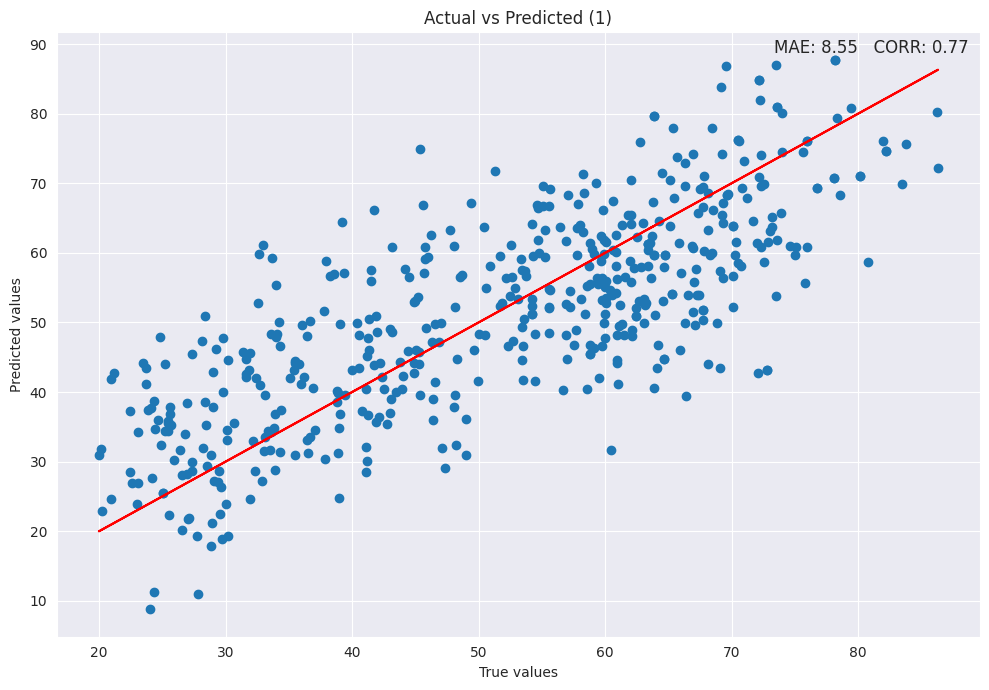

In [25]:
return_preds(inspector_parcellations_ridge)